# Error analysis of a Markov Chain
An detailed error analysis of the employed Markov-Chain in [Exercise 3](https://github.com/dschuechter/physics760_schuechter_krause/tree/master/Exercise03) will be shown in the following, where the long-range Ising model was studied in the 1-dim. case via a HMC-simulation.


## Number of integration steps
During the HMC procedure a leap-frog-integrator is used. The dependency of the numerically calculated integral on the number of integrations steps is studied. 

*Plot the first couple hundred trajectories of the MC history of {m}. How do the
trajectories differ for the two MCs?*

This is studied for parameters 

$$\begin{align}
\beta J = 0.1 && \beta h = 0.5 && N=5 && N_{md} \in \{4,100\}
\end{align}$$

Below the code (from last exercise w/ new param.) can be found. The two MCs differ in acceptance rate.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.special as sc
from IPython.display import Markdown, display

def printmd(string):
    display(Markdown(string))
nTrajs = 12850 # 50 more for thermalization (12800/64=200)
N_md_list = [100, 4]
N = 5
J=0.1
h=0.5
beta = 1
#pretty plots
def beauty_plot():
    plt.figure(figsize=(10,5))
    plt.minorticks_on()
    plt.rcParams["mathtext.fontset"]="cm"
    plt.rcParams['errorbar.capsize'] = 3
    plt.rcParams['mathtext.rm'] = 'serif'
    font={'family' : 'serif','size'   : 22}
    plt.rc("font",**font)
    plt.xticks(fontsize=22,fontname='DejaVu Serif')
    plt.yticks(fontsize=22,fontname='DejaVu Serif')
    plt.grid(color='black',linestyle=':')

def leap_frog(N_md, p_0, phi_0, J):
    epsilon = 1/N_md
    p, phi = p_0, phi_0
    #first leap-frog step
    phi = phi+epsilon/2*p
    for i in range(0,N_md-1):
        p=p-epsilon*(phi/(beta*J)-N*np.tanh(beta*h+phi))
        phi=phi+epsilon*p
    #last step of leap-frog
    p=p-epsilon*(phi/(beta*J)-N*np.tanh(beta*h+phi))
    phi=phi+epsilon/2*p
    return p, phi
#artificial hamiltonian
def art_hamiltonian(p, phi,J, N):
    return p**2/2+phi**2/(2*beta*J)-N*np.log(2*np.cosh(beta*h+phi))

def numerical(N_md):
    phi_list = [0] # arbitrary start value
    m_observe = []
    energy_observe = []
    prob=[]

    for traj in range(nTrajs):
        p_0 = np.random.normal(0,1) #sample randomly from normal dist.
        phi_0 = phi_list[-1] # each consecutive start value is phi from iteration before
        hamiltonian_0 = art_hamiltonian(p_0, phi_0, J/N, N) # calculate start hamilton
        # Calculate p' and phi'
        p, phi = leap_frog(N_md,p_0,phi_0, J/N)
        hamiltonian = art_hamiltonian(p, phi, J/N, N) # calculate end hamilton
        if np.random.uniform(0,1)<=np.exp(-beta*(hamiltonian-hamiltonian_0)):
            phi_list.append(phi) #accept
            prob.append(1)
        else:
            phi_list.append(phi_0) 
            prob.append(0)
    # Measurements
    m = []
    e=[]
    for phi in phi_list:
        m.append(np.tanh(beta*h+phi)) # take measuremente like described above
        #e.append(-1/N*(phi*phi/(2*beta*beta*J/N)+h*N*np.tanh(beta*h+phi)-1/(2*beta)))
    return m, phi_list, np.mean(prob)

m = []
phi = []
acceptance=[]
for N_md in N_md_list:
    num_res=numerical(N_md)
    m.append(num_res[0])
    phi.append(num_res[1])
    acceptance.append(num_res[2])

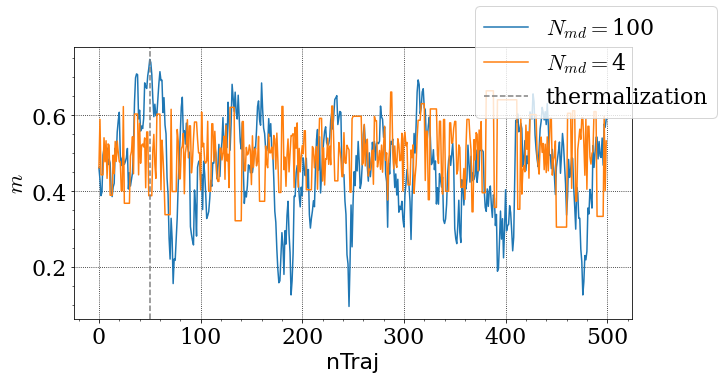

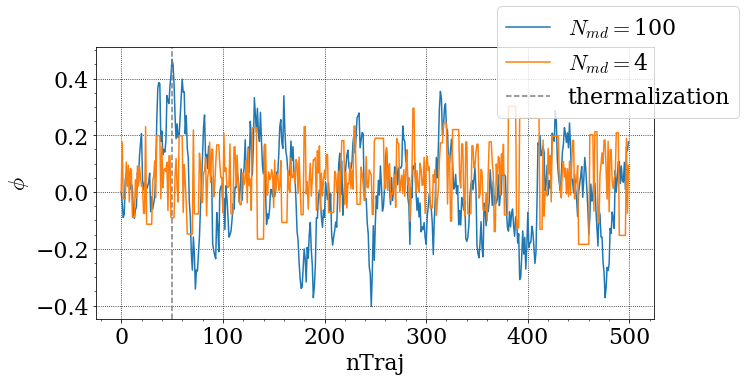

$\langle m \rangle = $0.4893505552865081

Acceptance rate for $N_m$$_d=100$ is 0.9996887159533074

Acceptance rate for $N_m$$_d=4$ is 0.6399221789883268

In [2]:
beauty_plot()
plt.plot(m[0][:500],label="$N_{md}=$%.d"%(N_md_list[0]))
plt.plot(m[1][:500],label="$N_{md}=$%.d"%(N_md_list[1]))
plt.axvline(x=50, color="gray", ls="--", label="thermalization")
plt.legend(bbox_to_anchor=(0.7, 0.7))
plt.xlabel("nTraj", fontsize=22)
plt.ylabel("$m$", fontsize=22)
plt.show()

beauty_plot()
plt.plot(phi[0][:500],label="$N_{md}=$%.d"%(N_md_list[0]))
plt.plot(phi[1][:500],label="$N_{md}=$%.d"%(N_md_list[1]))
plt.axvline(x=50, color="gray", ls="--", label="thermalization")
plt.xlabel("nTraj")
plt.ylabel("$\\phi$")
plt.legend(bbox_to_anchor=(0.7, 0.7))
plt.show()

# Apply thermalization for the first 50 elements
m[0]=m[0][50:]
m[1]=m[1][50:]
printmd(f"$\\langle m \\rangle = ${np.mean(m[0])}")
printmd(f"Acceptance rate for $N_m$$_d=100$ is {acceptance[0]}")
printmd(f"Acceptance rate for $N_m$$_d=4$ is {acceptance[1]}")


## Autocorrelation of Markov-Chain elements

Elements of a Markov-Chain are not independent. To study their behaviour the autocorrelation function $$\Gamma^{(m)}(\tau)=\frac{1}{\#(k,l)}\sum_{(k,l):\tau=|k-l|}(m_k-\bar{m}_N)(m_l-\bar{m}_N)$$ resp. the normalized correlation function $$C(\tau)=\frac{\bar{\Gamma}^{(m)}(\tau)}{\bar{\Gamma}^{(m)}(0)}$$ are plotted for the two different values of $N_{md}.$

*Implement the straightforward estimator $C(\tau)$ and plot the function of $C(\tau)$ for your generated data sets.*

The autocorrelation function is implemented below and also plotted.

In [3]:
m_mean = np.mean(m[0]) # use mean value estimated before

def gamma(t, m):# autocorrelation  function
    m_sum = 0
    for i in range(len(m)-t):
        m_sum += (m[i]-m_mean)*(m[i+t]-m_mean)
    return 1/(len(m)-t)*m_sum

t_list = np.linspace(0,50,51,dtype="int")#autocorrelation time
y_0 = []
y_1 = []
gamma_0_m0 = gamma(0, m[0])
gamma_0_m1 = gamma(0, m[1])
for t in t_list:
    y_0.append(gamma(t, m[0])/gamma_0_m0)
    y_1.append(gamma(t, m[1])/gamma_0_m1)


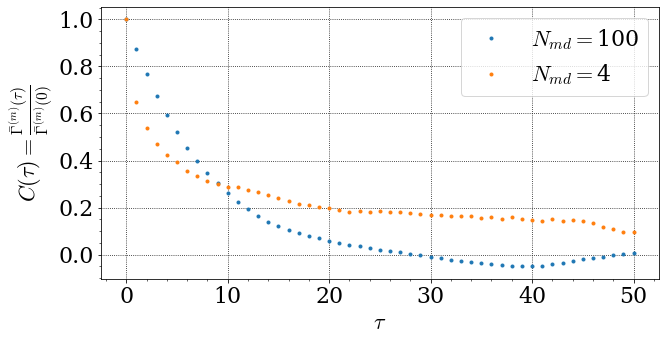

In [4]:
beauty_plot()
plt.plot(t_list,y_0,".", label="$N_{md}=$%.d"%(N_md_list[0]))
plt.plot(t_list,y_1,".",label="$N_{md}=$%.d"%(N_md_list[1]))
plt.xlabel("$\\tau$")
plt.ylabel("$C(\\tau)=\\frac{\\bar{\\Gamma}^{(m)}(\\tau)}{\\bar{\\Gamma}^{(m)}(0)}$")
plt.legend()
plt.show()

## Blocking of data
Blocking of data reduces autocorrelation. "Blocking" here means that for a block size of $b$ for every $b$ steps in the initial data array these $b$ values get succesively replaced by their mean.

*Generate blocked data for $b =2,4,8,16, 32$, and $64$, and calculate the autocorrelation for each blocked list. Does it behave the way you expect? With the blocked lists, estimate
the naive standard error with $\frac{\sigma}{\sqrt{Nb}}$ and observe the behavior, where $\sigma$ is the standard
deviation of the blocked list.*

Below this was implemented. As expected, autocorrelation quickly drops to 0 for larger bins while the naive error asymptotically gets larger.

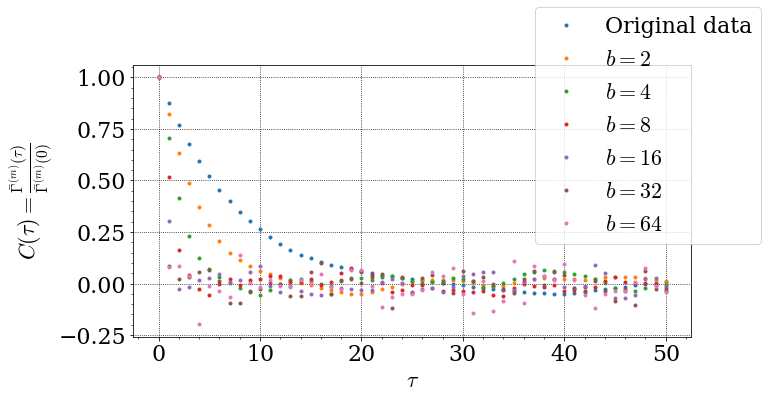

In [5]:
def block_generator(b, m):
    blocked_data = []
    x = 0
    for i in range(0,int((nTrajs-50)/b)):
        blocked_data.append(np.mean(m[x:x+b]))
        x = x+b
    return blocked_data
            
b_list = [2,4,8,16,32,64]
blocked_list = []
for b in b_list:
    blocked_list.append(block_generator(b, m[0]))#block the data
    

t_list = np.linspace(0,50,51,dtype="int")
y_list = []
beauty_plot()
plt.plot(t_list,y_0,".", label="Original data")
for i in range(0, len(b_list)):
    y_list.append([])
    gamma_0 = gamma(0, blocked_list[i])
    for t in t_list:
        y_list[i].append(gamma(t, blocked_list[i])/gamma_0)
    plt.plot(t_list,y_list[i],".", label="$b=%.d$"%(b_list[i]))#plot the data
plt.xlabel("$\\tau$")
plt.ylabel("$C(\\tau)=\\frac{\\bar{\\Gamma}^{(m)}(\\tau)}{\\bar{\\Gamma}^{(m)}(0)}$")
plt.legend(bbox_to_anchor=(0.7,0.3))
plt.show()

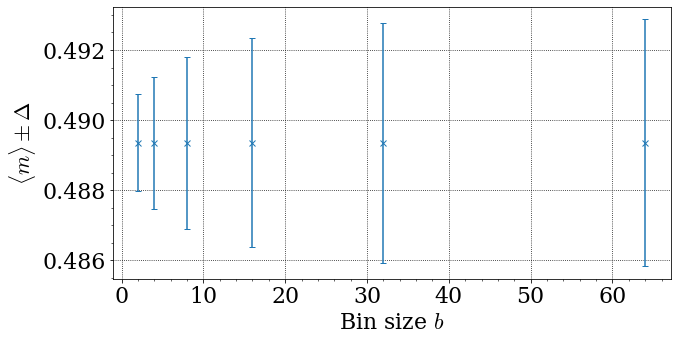

In [6]:
std = []
for i in range(0, len(b_list)):
    std.append(np.std(blocked_list[i])/np.sqrt((nTrajs-50)/b_list[i]))
beauty_plot()
plt.errorbar(b_list,[m_mean for i in range(len(b_list))],yerr=std, ls="None", marker="x")
plt.ylabel("$\\langle m \\rangle \pm \\Delta$")
plt.xlabel("Bin size $b$")
plt.show()

## Bootstrap error
With the bootstrap procedure one can estimate unbiased errors. The following algorithm was implemented:

* For a given list of obersables $\{m\}$ a new list will be created ("bootstrap list"), that is as long as the original and contains randomly picked elements from said list. The bootstrap list will be labeled as $\{m\}^0_{bs}$
* This procedure will be $N_{bs}$ repeated:
$$\{\{m\}\}_{bs}=\{\{m\}_{bs}^0,\{m\}_{bs}^1,\dots,\{m\}_{bs}^{N_{bs}-1}\}$$
* Calculate the mean of every bootstrap list:
$$\{\bar{m}\}_{bs}=\{\bar{m}^0_{bs},\bar{m}^1_{bs},\dots,\bar{m}^{N_{bs}-1}_{bs}\}$$
* The bootstrap error $\delta m$ of the expactation value $\langle m \rangle$ is given as the standrad deviation of $\{\bar{m}_{bs}\}$

*Code up the bootstrap procedure and calculate the bootstrap error for your blocked
list of $\{m\}$. Investigate the stability of the error as a function of $N_{bs}$. How does the bootstrap
error compare with your naive estimate from above?*
Below the bootstrap error is implemented and also directly compared to the naive error. One can see that for a large number of bootstrap iterations $N_{bs}$ the error converges around a specific value. We found $N_{bs}\approx100$ to sufficient.

In [7]:
def bootstrap_error(s, nBS): 
    n=len(s)
    bsmean = np.array([])
    for bs in range(nBS):
        index = np.random.randint(n, size=n)#randomly pull from m-array
        bsmean = np.append(bsmean, np.array([s[index[i]] for i in range(n)]).mean())#put mean of randomly pulled ms in a new array
    return bsmean.std() # return the bootstrap error estimate

nBS_list = np.linspace(10,1000,50)
m_bootstrap_list = [bootstrap_error(m[0], int(nBS)) for nBS in nBS_list]


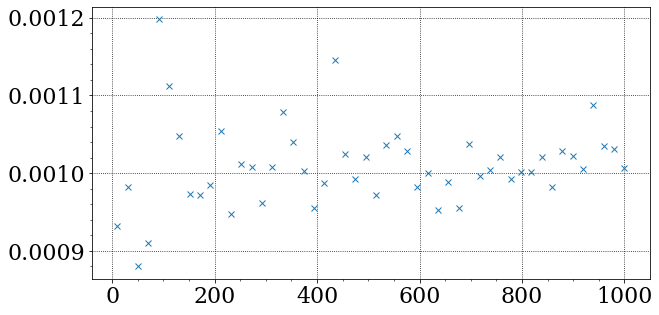

In [8]:
beauty_plot()
plt.plot(nBS_list, m_bootstrap_list, ls="None", marker = "x")
plt.show()

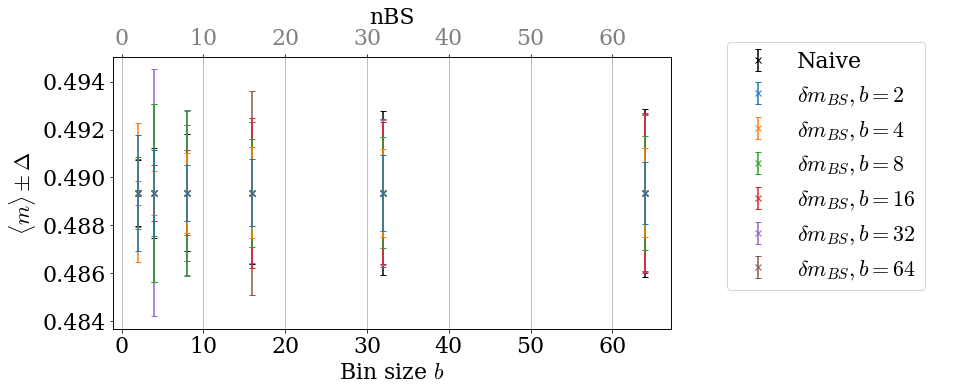

In [9]:
fig, ax1 = plt.subplots(figsize=(10,5))
color_1 = 'black'
color_2 = 'tab:orange'
ax1.set_xlabel('Bin size $b$')
ax1.set_ylabel("$\\langle m \\rangle \pm \\Delta$", color="black")
ax1.tick_params(axis='x', labelcolor=color_1)
ax2 = ax1.twiny()  # instantiate a second axes that shares the same y-axis
ax2.set_xlabel("nBS", color="black")  # we already handled the y-label with ax1
ax1.errorbar(b_list,[m_mean for i in range(len(b_list))],yerr=std, ls="None", marker="x", c=color_1, label="Naive")
for j in range(len(b_list)):
    ax2.errorbar(b_list,[m_mean for i in range(len(b_list))],yerr=[bootstrap_error(blocked_list[j], b_list[i]) for i in range(len(b_list))], ls="None", marker="x", label="$\\delta m_{BS}, b=%d$"%(b_list[j]), zorder=-j)
ax2.tick_params(axis='x', labelcolor='gray')
plt.grid()
fig.legend(bbox_to_anchor=(1.3,1))
plt.show()

One can see by directly comparing the two differently estimated errors that the bootstrap method leads to significantly smaller errors than the naive error as long as bin size is small. For larger bin sizes the bootstrap error estimates the naive error.